In [31]:
import numpy as np
from sklearn.cluster import MiniBatchKMeans
from numpy.random import rand
import scipy.ndimage
import json
import matplotlib.pyplot as plt

In [2]:
RANDOM_SEED = 42
cluster_number = 256
weights = rand(300,784)

### Clustering

In [3]:
def reshape_weights_for_kmeans(weights):
    return np.hstack(weights).reshape(-1,1)

def build_clusters(cluster,weights):
    kmeans = MiniBatchKMeans(n_clusters=cluster,random_state=RANDOM_SEED)
    kmeans.fit(reshape_weights_for_kmeans(weights))
    return kmeans.cluster_centers_

In [40]:
def nearest_centroid_index(centers,value):
    centers = np.asarray(centers)
    idx = (np.abs(centers - value)).argmin()
    return idx

def nearest_centroid(centers,value):
    centers = np.asarray(centers)
    idx = (np.abs(centers - value)).argmin()
    return centers[idx]

### Matrix

In [47]:
def redefine_weights(weights,centers):
    arr_ret = np.empty_like(weights).astype(np.int16)
    for i, row in enumerate(weights):
        for j, col in enumerate(row):
            arr_ret[i,j] = nearest_centroid_index(centers,weights[i,j])
    return arr_ret

In [42]:
def index_matrix_to_matrix(a,d):
    new_array = np.empty_like(a).astype(float)
    for i,row in enumerate(a):
        for j,col in enumerate(row):
            new_array[i,j] = d[a[i,j]][0]
    return new_array

In [7]:
def centroid_gradient_matrix(idx_matrix,gradient,cluster):
    return scipy.ndimage.sum(gradient,idx_matrix,index=range(cluster))

### Dictionary

In [8]:
# map (i,j) -> k
def dict_index_to_cluster(weights,centers):
        dict_ret = {}
        for i, row in enumerate(weights):
            for j, col in enumerate(row):
                dict_ret[(i,j)] = nearest_centroid_index(centers,weights[i,j])
        return dict_ret

# map k -> (i,j)
def dict_cluster_to_index(dict_idx):
    dict_ret = {}
    for k,v in dict_idx.items():
        if v in dict_ret:
            dict_ret[v] += [k]
        else:
            dict_ret[v] = [k]
    return dict_ret

In [43]:
def index_dict_to_matrix(dict_index,dict_values,shape):
    coord_array = np.asarray(list(dict_index.values()))
    return dict_values[coord_array].reshape(shape)

In [44]:
def centroid_gradient_dict(K_Index,W_Matrix):
    tmpindex = dict((key, ([x for x, _ in value], [y for _, y in value])) for key, value in K_Index.items())
    return [W_Matrix[value[0],value[1]].sum() for value in tmpindex.values()]

### Variables

In [45]:
centers = build_clusters(cluster_number,weights)
dict_index = dict_index_to_cluster(weights,centers)
dict_cluster = dict_cluster_to_index(dict_index)
matrix_index = redefine_weights(weights,centers)

### Testing

In [46]:
%timeit index_matrix_to_matrix(matrix_index,centers)
%timeit index_dict_to_matrix(dict_index,centers,(300,784))

119 ms ± 1.41 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
17.2 ms ± 388 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [13]:
%timeit centroid_gradient_matrix(matrix_index,weights,cluster_number)
%timeit centroid_gradient_dict(dict_cluster,weights)

1.72 ms ± 79.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
82.1 ms ± 6.83 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Transform

In [22]:
def dict_to_index_matrix(dict_cluster):
    arr_ret = np.zeros((300,785))
    for k,v in dict_cluster.items():
        for i in v:
            arr_ret[i] = k
    return arr_ret

def dict_to_index_matrix2(dict_index,shape):
    return np.asarray(list(dict_index.values())).reshape(shape)

In [48]:
%timeit dict_to_index_matrix(dict_cluster)
%timeit dict_to_index_matrix2(dict_index,(300,784))

50.1 ms ± 2.27 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
17 ms ± 473 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


# HELPER FUNCTION

#### Reading from JSON

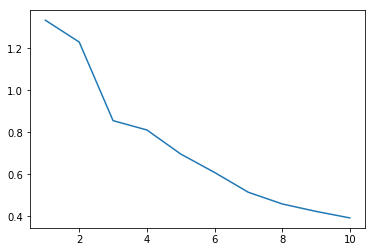

In [32]:
def get_data_from_json(file):
    with open(file) as f:
        return json.load(f)
    
def get_list_values_from_json(data,field,variable):
    return [element[field] for element in data[variable]]

data = get_data_from_json('log/Log_Cluster_Setting_Mean.json')
x = get_list_values_from_json(data,"cluster","cluster_mean")
y = get_list_values_from_json(data,"mean","cluster_mean")

plt.plot(x[:10],y[:10])
plt.show()

#### Cluster mean

In [38]:
def mean_distance(weights,centroids):
    tot = 0.
    for i, row in enumerate(weights):
        for j, col in enumerate(row):
            weight = weights[i,j]
            centroid = nearest_centroid(centroids,weight)[0]
            tot += np.sqrt((weight - centroid)**2)
    return tot / ((i+1)*(j+1))

In [41]:
def find_clusters_number(values,n_from,n_to,n_jump):
    result = {}
    for i in range(n_from,n_to+1,n_jump):
        kmeans = MiniBatchKMeans(n_clusters=i,random_state=RANDOM_SEED)
        kmeans.fit(reshape_weights_for_kmeans(values))
        mean = mean_distance(values,kmeans.cluster_centers_)
        result[i] = mean
        print("Mean for %s clusters %f " % (str(i).zfill(3),mean))
    return result
        
means_cluster_1_10 = find_clusters_number(weights,1,101,10)

Mean for 001 clusters 0.249997 
Mean for 011 clusters 0.022929 
Mean for 021 clusters 0.012160 
Mean for 031 clusters 0.008341 
Mean for 041 clusters 0.006128 
Mean for 051 clusters 0.004958 
Mean for 061 clusters 0.004320 
Mean for 071 clusters 0.003624 
Mean for 081 clusters 0.003231 
Mean for 091 clusters 0.002785 
Mean for 101 clusters 0.002537 
